In [19]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [21]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
TEMPERATURES_CSV = '/content/sunspotnorm.csv'

In [22]:
def parse_data_from_file(filename):

    times = []
    temperatures = []

    with open(filename) as csvfile:

        ### START CODE HERE
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            temperatures.append(float(row[1]))
            times.append(row[0])
        ### END CODE HERE

    return times, temperatures

In [4]:
# visual relationship

def visual_relationship(T, i, j):
    """
    Calculates the visual relationship between nodes i and j in a time series T.

    Args:
        T (array-like): The time series.
        i (int): The index of the first node.
        j (int): The index of the second node.

    Returns:
        int: If nodes i and j are visible, returns 1. Otherwise, returns 0.
    """

    # Calculate the slope between nodes i and j
    slope_i_j = (T[j][1] - T[i][1]) / (j - i)

    # Calculate the slopes between node i and each node between i and j
    slopes_i_theta = ((T[i+1:j+1,1] - T[i][1]) / (np.arange(j-i)+1)).reshape(-1,1)

    # Find the index of the maximum slope between node i and each node between i and j
    max_slope_idx = np.max(slopes_i_theta)

    # If the index of the maximum slope is equal to i, return 1. Otherwise, return 0.
    if max_slope_idx == slope_i_j:
        return 1
    else:
        return 0

# visual matrix

def visual_matrix(T):
    """
    Calculates the visual matrix A for the time series T.

    Args:
        T (array-like): The time series.

    Returns:
        ndarray: The visual matrix A.
    """

    n = T.shape[0]
    A = np.zeros((n, n), dtype=int)

    for i in range(n):
        print(f"{i} iteration : Visual Matrix")
        for j in range(i+1, n):
            A[i][j] = visual_relationship(T, i, j)
            A[j][i] = A[i][j]


    return A

# Enhanced visibility graph

def enhanced_visibility_graph(T, A):
    """
    Calculates the enhanced visibility graph (EVG) for the time series T and its visual matrix A.

    Args:
        T (ndarray): The time series, where each row is of the form (time, value).
        A (ndarray): The visual matrix A for the time series.

    Returns:
        ndarray: The enhanced adjacency matrix B.
    """

    n = T.shape[0]
    B = np.zeros((n, n))

    for i in range(n):
        print(f"{i} iteration : evg")
        degree = np.sum(A[i])
        for j in range(n):
            if A[i][j] == 1:
                B[i][j] = (A[i][j] * T[j][1]) / degree

    return B

# Compressed Series

def compress_evg(B):
    """
    Compresses the enhanced adjacency matrix B generated by the EVG algorithm to generate a Deep Visibility Series (DVS) module.

    Args:
        B (ndarray): The enhanced adjacency matrix B.

    Returns:
        ndarray: The compressed DVS sequence.
    """

    n = B.shape[0]
    zip_ = np.zeros(n)

    for i in range(n):
        print(f"{i} iteration : zip")
        zip_[i] = np.sum(B[:,i])

    return zip_

In [24]:
times, temperatures = parse_data_from_file('/content/sunspotnorm.csv')
time_series = np.array((range(len(times)),temperatures))
series = np.array([(i+1,num) for i,num in enumerate(temperatures)])
print(series[:5])

[[1. 0.]
 [2. 0.]
 [3. 0.]
 [4. 0.]
 [5. 0.]]


In [25]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:

    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    time_series = np.array([(i+1,num) for i,num in enumerate(temperatures)])
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    #ZIP = compress_evg(enhanced_visibility_graph(time_series,visual_matrix(time_series)))
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

#plt.figure(figsize=(10, 6))
#plot_series(G.TIME, G.SERIES)
#plot_series(G.TIME, G.ZIP)
#plt.show()


In [26]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)


In [27]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)


In [28]:
def create_uncompiled_model():


    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=60, kernel_size=5,
 strides=1, padding="causal",
 activation="relu",
 input_shape=[None, 1]),
 tf.keras.layers.LSTM(60, return_sequences=True),
 tf.keras.layers.LSTM(60),
 tf.keras.layers.Dense(30, activation="relu"),
 tf.keras.layers.Dense(10, activation="relu"),
 tf.keras.layers.Dense(1)
    ])

    return model

In [29]:
# Test your uncompiled model

# Create an instance of the model
uncompiled_model = create_uncompiled_model()

# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):

    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)

# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

Testing model prediction with input of shape (32, 64)...
1/1 [==============================] - 1s 1s/step
Your current architecture is compatible with the windowed dataset! :)


In [30]:
def adjust_learning_rate(dataset):

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    # Select your optimizer
    optimizer =  tf.keras.optimizers.SGD(learning_rate=0.0028, momentum=0.9)

    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [31]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 [==============================] - 10s 71ms/step - loss: 0.0015 - mae: 0.0269 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - 5s 67ms/step - loss: 0.0014 - mae: 0.0286 - lr: 1.1220e-04
Epoch 3/100
77/77 [==============================] - 7s 85ms/step - loss: 0.0013 - mae: 0.0304 - lr: 1.2589e-04
Epoch 4/100
77/77 [==============================] - 6s 71ms/step - loss: 0.0012 - mae: 0.0319 - lr: 1.4125e-04
Epoch 5/100
77/77 [==============================] - 5s 69ms/step - loss: 0.0012 - mae: 0.0332 - lr: 1.5849e-04
Epoch 6/100
77/77 [==============================] - 7s 86ms/step - loss: 0.0012 - mae: 0.0340 - lr: 1.7783e-04
Epoch 7/100
77/77 [==============================] - 6s 73ms/step - loss: 0.0011 - mae: 0.0347 - lr: 1.9953e-04
Epoch 8/100
77/77 [==============================] - 7s 94ms/step - loss: 0.0011 - mae: 0.0350 - lr: 2.2387e-04
Epoch 9/100
77/77 [==============================] - 6s 80ms/step - loss: 0.0011 - mae: 0.0357 - lr: 2.

(0.0001, 10.0, 0.0, 10.0)

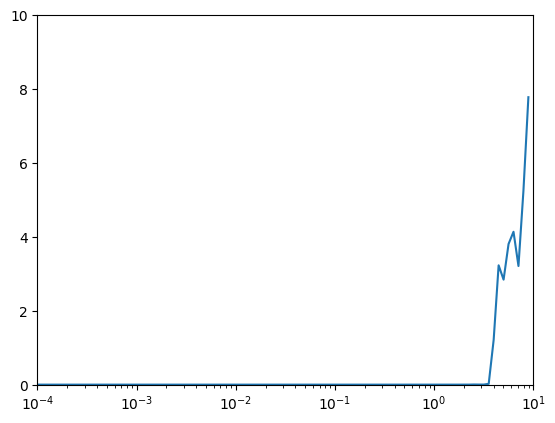

In [32]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

In [33]:
l=lr_history.history["lr"][lr_history.history["loss"].index(min(lr_history.history["loss"]))]
l

0.4466836

In [34]:
def create_model():


    model = create_uncompiled_model()

    optimizer = tf.keras.optimizers.SGD(learning_rate = l,momentum = 0.9)
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])


    return model

In [35]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 [==============================] - 10s 69ms/step - loss: 0.0014 - mae: 0.0388
Epoch 2/50
77/77 [==============================] - 7s 83ms/step - loss: 0.0013 - mae: 0.0367
Epoch 3/50
77/77 [==============================] - 7s 83ms/step - loss: 0.0013 - mae: 0.0374
Epoch 4/50
77/77 [==============================] - 5s 67ms/step - loss: 0.0012 - mae: 0.0353
Epoch 5/50
77/77 [==============================] - 7s 82ms/step - loss: 0.0012 - mae: 0.0358
Epoch 6/50
77/77 [==============================] - 7s 84ms/step - loss: 0.0012 - mae: 0.0355
Epoch 7/50
77/77 [==============================] - 6s 69ms/step - loss: 0.0011 - mae: 0.0338
Epoch 8/50
77/77 [==============================] - 6s 78ms/step - loss: 0.0012 - mae: 0.0350
Epoch 9/50
77/77 [==============================] - 7s 86ms/step - loss: 0.0011 - mae: 0.0343
Epoch 10/50
77/77 [==============================] - 6s 74ms/step - loss: 0.0011 - mae: 0.0329
Epoch 11/50
77/77 [==============================] - 6s 70

In [36]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [37]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [41]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
#plt.figure(figsize=(10, 6))
#plot_series(time_valid, series_valid)
#plot_series(time_valid, rnn_forecast)

2302/2302 [==============================] - 65s 28ms/step


In [42]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 0.01, mae: 0.07 for forecast
